# Plot curves and confusion matrix

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

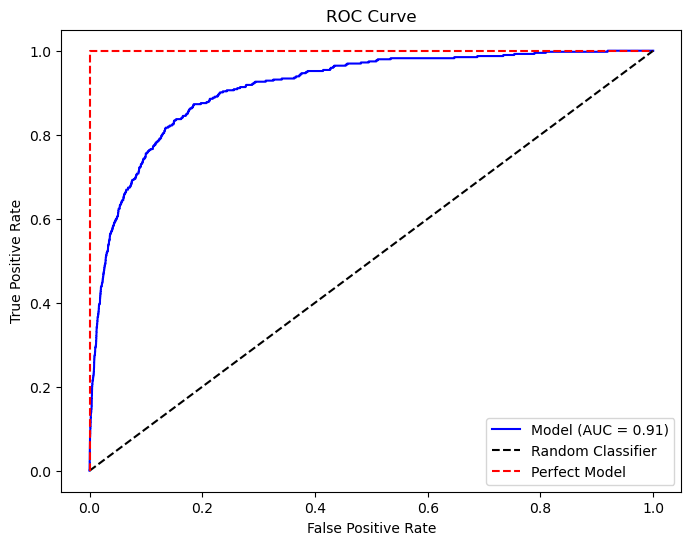

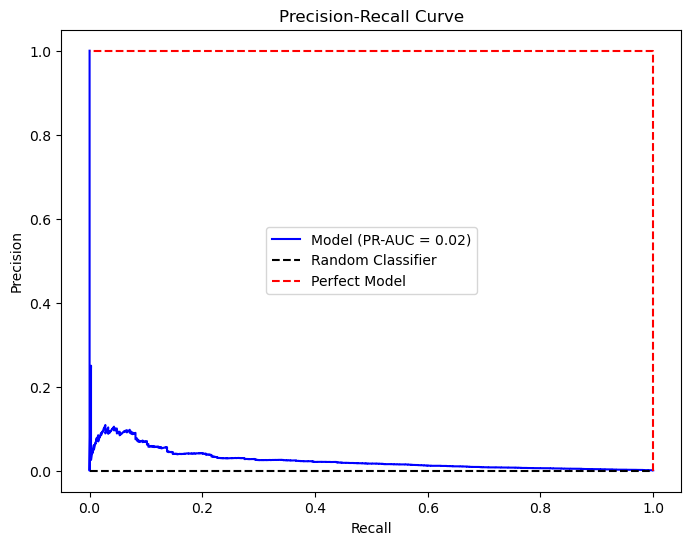

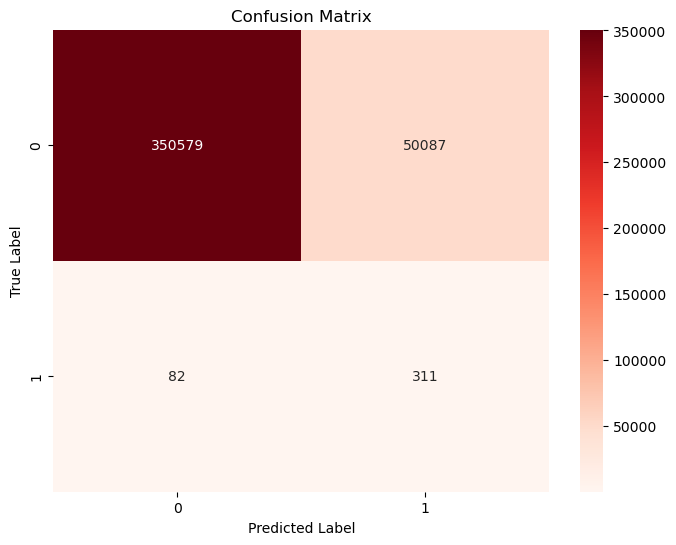

In [5]:
# Read data
curves_data = np.load('/home/falcon/student3/tfg_ivan/data/predict_iToBoS_35e_192_64bs_3e-05lr_yes_metadata_BCEWithLogitsLoss_OSx150_USRatio_1:1_on_ISIC_crops_train_curves.npz')
cm_data = np.load('/home/falcon/student3/tfg_ivan/data/predict_iToBoS_35e_192_64bs_3e-05lr_yes_metadata_BCEWithLogitsLoss_OSx150_USRatio_1:1_on_ISIC_crops_train_confusion_matrix.npz')

# Curves
fpr = curves_data['fpr']
tpr = curves_data['tpr']
roc_auc_score = np.trapz(tpr,fpr)

precision = curves_data['precision']
recall = curves_data['recall']
pr_auc_score = np.trapz(recall, precision)

# Plot ROC-AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Model (AUC = {roc_auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Classifier')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', color='red', label='Perfect Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot Precision-Recall (PR-AUC) curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Model (PR-AUC = {pr_auc_score:.2f})')
plt.plot([0, 1], [0, 0], linestyle='--', color='black', label='Random Classifier')
plt.plot([1, 1, 0], [0, 1, 1], linestyle='--', color='red', label='Perfect Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Load & Plot Confusion matrix
confusion_matrix = cm_data['confusion_matrix']

# Plotear la matriz de confusión
plt.figure(figsize=(8, 6))
labels = np.array([['True Negative', 'False Positive'], ['False Negative', 'True Positive']])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot augmentation examples

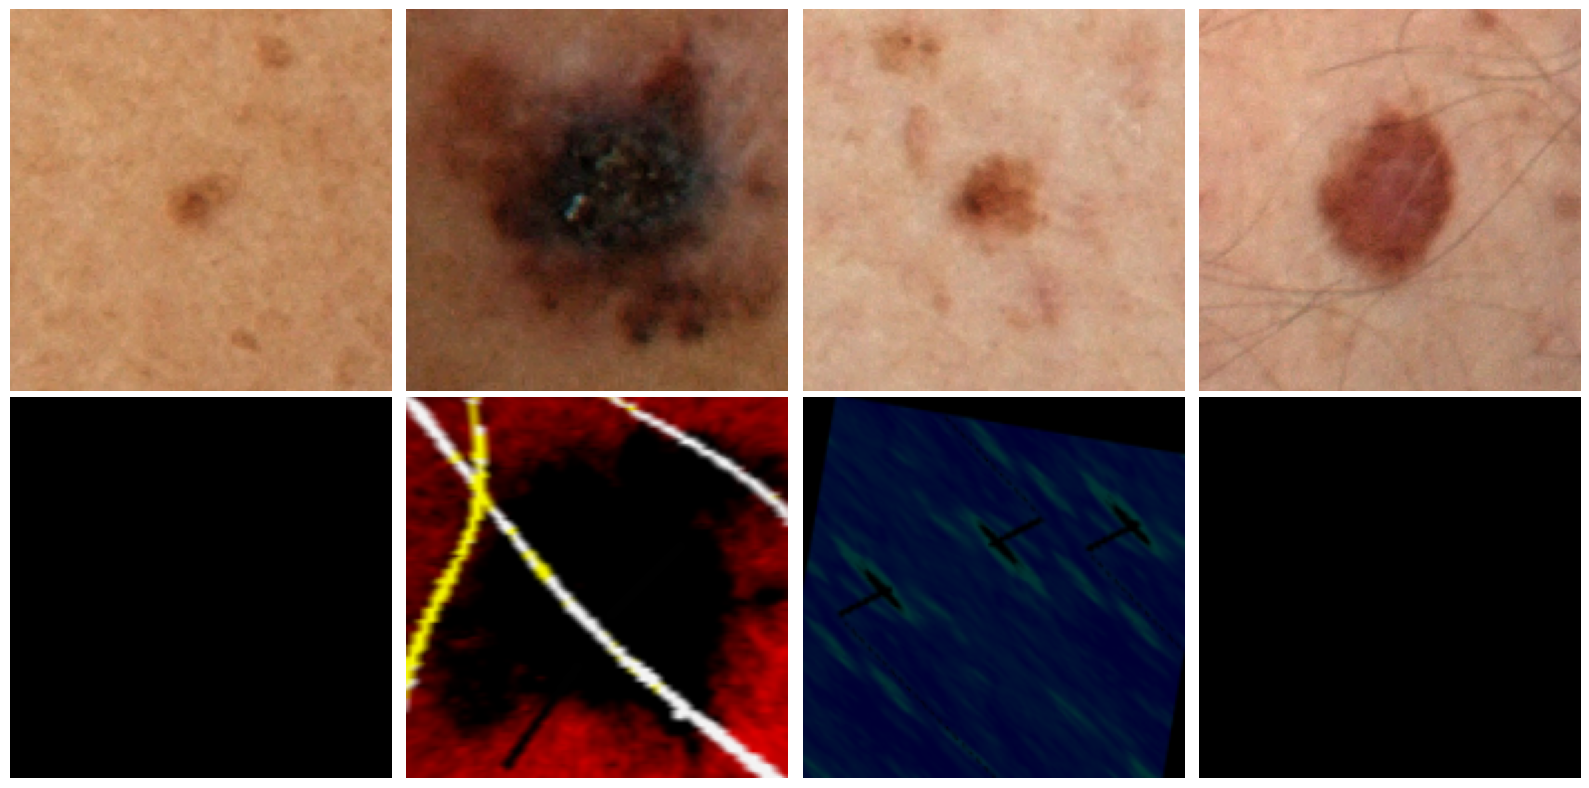

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations
import random
import os
from datasets import CustomHairAugmentation, CustomHairDrawingAugmentation

# Suponiendo que las imágenes están en archivos locales
image_paths = ["/home/falcon/student3/tfg_ivan/data/iToBoS_internal_ISIC_2024/FCRB/crops/20210708091319135/20210708091319135-0bdef258-b1a6-5a77-8e12-eef915525474.jpg",
               "/home/falcon/student3/tfg_ivan/data/iToBoS_internal_ISIC_2024/FCRB/crops/tags/1_20230808112925964-786cbc6b-d000-5ed9-89ad-97b690100622.jpg",
               "/home/falcon/student3/tfg_ivan/data/iToBoS_internal_ISIC_2024/FCRB/crops/20210720085019245/20210720085019245-0d2ece97-1048-553b-acd5-d4c1437aaf52.jpg",
               "/home/falcon/student3/tfg_ivan/data/iToBoS_internal_ISIC_2024/FCRB/crops/tags/4_20210913123358559-c5f42732-219f-58a7-abff-12d6be4cfba2.jpg",
               ]

images = [cv2.imread(path) for path in image_paths]

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
image_size = 192

# Definir las augmentations con probabilidades específicas
augmentations = albumentations.Compose([
                albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
                CustomHairAugmentation(hairs=5, hairs_folder="/home/falcon/student3/tfg_ivan/data/false_hairs", always_apply=False, p=0.5),
                CustomHairDrawingAugmentation(hairs=4, width=(1,2), always_apply=False, p=0.5),
                albumentations.Transpose(p=0.5),
                albumentations.VerticalFlip(p=0.5),
                albumentations.HorizontalFlip(p=0.5),
                albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
                albumentations.RandomBrightness(limit=0.2, p=0.75),
                albumentations.RandomContrast(limit=0.2, p=0.75),
                albumentations.OneOf([
                    albumentations.MotionBlur(blur_limit=5),
                    albumentations.MedianBlur(blur_limit=5),
                    albumentations.GaussianBlur(blur_limit=5),
                    albumentations.GaussNoise(var_limit=(5.0, 30.0)),
                ], p=0.7),

                albumentations.OneOf([
                    albumentations.OpticalDistortion(distort_limit=1.0),
                    albumentations.GridDistortion(num_steps=5, distort_limit=1.),
                    albumentations.ElasticTransform(alpha=3),
                ], p=0.7),

                # albumentations.CLAHE(clip_limit=4.0, p=0.7),
                albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
                albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
                albumentations.Resize(image_size, image_size),
                albumentations.Cutout(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7),
                # albumentations.Normalize()
            ])

# Aplicar augmentations
augmented_images = [augmentations(image=image)['image'] for image in images]

# Convertir las imágenes de BGR a RGB (porque OpenCV usa BGR por defecto)
images_rgb = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]
augmented_images_rgb = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in augmented_images]

# Plotear las imágenes originales y augmentadas
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    axes[0, i].imshow(images_rgb[i])
    # axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(augmented_images_rgb[i])
    # axes[1, i].set_title(f'Augmented {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
